
Here is Fashion MNIST training from scratch without using model.fit(...) method and keras.optimizers.
Main purpose of such approach: understanding NN training process

This example gives accuracy = 80% (+-0.5%) after 30 epoch on test dataset (please, check it).

**Task**: without changing Neural Network architecture reach accuracy on **test** dataset>= 90%. (i.e. model must contain only 3 trainable layers and they must be Fully Connected (Dense) as it is below, 
but you can add non-trainable parameters, decrease neurons number) 

**Auxiliary task**: create evaluation function to calculate accuracy for this classification problem, create your custom loss_function(y_true, y_pred), describe impact of each your improvement

It is prohibited to use: model.fit(...) and tf.keras.optimizers(but it is allowed to inherit from tf.optimizers.Optimizer and write your own optimizer). So, you have to implement train process and optimizer (like at this example).


Advices: You are able to change :


*   pre-processing
*   data augmentation
*   optimization process (SGD + momentum, Adam, RMSProp, etc)
*   regularization
*   learning rate schedule
*   loss function
*   add Normalization layers without training parameters
*   your approach

It is recommended to describe why your changes lead to the accuracy improvement

## **Importing all necessary packages**

In [ ]:
import math
import random
random.seed(2022)
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.random.set_seed(2022)
import tensorflow_datasets as tfds
print(tf.__version__)

from matplotlib import rcParams
from matplotlib import pyplot as plt

2.8.2


# **Data loading**

In [ ]:
# splitting train MNIST Fashion data into validation and training sets
# and loading test data
(train_data, validation_data), info  = tfds.load("fashion_mnist", with_info = True, split = ["train[:98%]", "train[98%:]"])
test_data = tfds.load("fashion_mnist", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8S28TD/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8S28TD/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


#**Exploratory Data Analysis**

In [ ]:
names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",	"Bag",	"Ankle boot"]

In [ ]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams["figure.figsize"] = [10,10]
rcParams['xtick.labelbottom'] = False

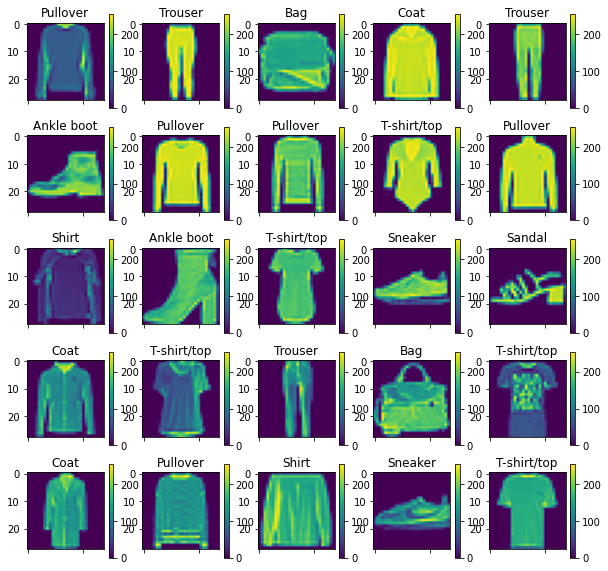

In [ ]:
for idx, elem in enumerate(train_data.take(25)):
  plt.subplot(5, 5, idx+1, title = names[elem['label'].numpy()] )
  plt.imshow(elem['image'][:,:,0])
  # adding plt.colorbar() to get a pixel values range
  plt.colorbar()

In [ ]:
TRAIN_DATA_LENGTH = len(list(train_data))
VALIDATION_DATA_LENGTH = len(list(validation_data))
TEST_DATA_LENGTH = len(list(test_data))

print("Size of the training dataset: {} samples".format(TRAIN_DATA_LENGTH))
print("Size of the validation dataset: {} samples".format(VALIDATION_DATA_LENGTH))
print("Size of the test dataset: {} samples".format(TEST_DATA_LENGTH))

Size of the training dataset: 58800 samples
Size of the validation dataset: 1200 samples
Size of the test dataset: 10000 samples


In [ ]:
# Next step is to get the distribution of classes per each sub-set 
# (training, validation and test)
LABELS = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_distribution_of_classes(data, num_of_samples):
  """Computes the distribution of each class in a subset.
Args:
  data: a `PrefetchDataset` representing one of three subsets.
  num_of_samples: a `int` value that shows the length of a subset.
Returns:
  A `dict` {int: int} representing number of samples per each class.
  """
  distribution_dict = {val:0 for val in range(10)}
  for idx, elem in enumerate(data.take(num_of_samples)):
    distribution_dict[elem['label'].numpy()] += 1

  return distribution_dict

def print_distribution_of_classes(dist_dictionary):
  """Prints the distribution of each class in a subset.
Args:
  dist_dictionary: a `dict`  {int: int} representing number of samples per each class.
  """
  for i in range(10):
    print("{:<12s}:   {}".format(LABELS[i], dist_dictionary[i]))

def plot_distribution(dist_dictionary):
  """Plots the barplot for distribution of each class in a subset.
Args:
  dist_dictionary: a `dict`  {int: int} representing number of samples per each class.
  """
  for i in range(10):
    plt.bar(i, dist_dictionary[i], align='center')
  plt.xticks(np.arange(10), LABELS.values(), rotation=45, visible = True)
  plt.show()

In [ ]:
# Distribution of the training data
train_distribution = get_distribution_of_classes(train_data, TRAIN_DATA_LENGTH)
print_distribution_of_classes(train_distribution)

T-shirt/top :   5868
Trouser     :   5873
Pullover    :   5865
Dress       :   5886
Coat        :   5884
Sandal      :   5872
Shirt       :   5900
Sneaker     :   5884
Bag         :   5886
Ankle Boot  :   5882


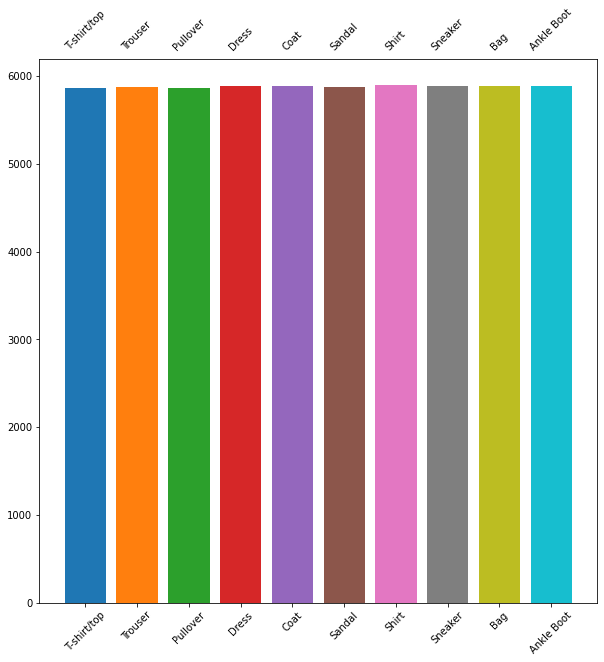

In [ ]:
plot_distribution(train_distribution)

In [ ]:
# Distribution of the validation data
validation_distribution = get_distribution_of_classes(validation_data, VALIDATION_DATA_LENGTH)
print_distribution_of_classes(validation_distribution)

T-shirt/top :   132
Trouser     :   127
Pullover    :   135
Dress       :   114
Coat        :   116
Sandal      :   128
Shirt       :   100
Sneaker     :   116
Bag         :   114
Ankle Boot  :   118


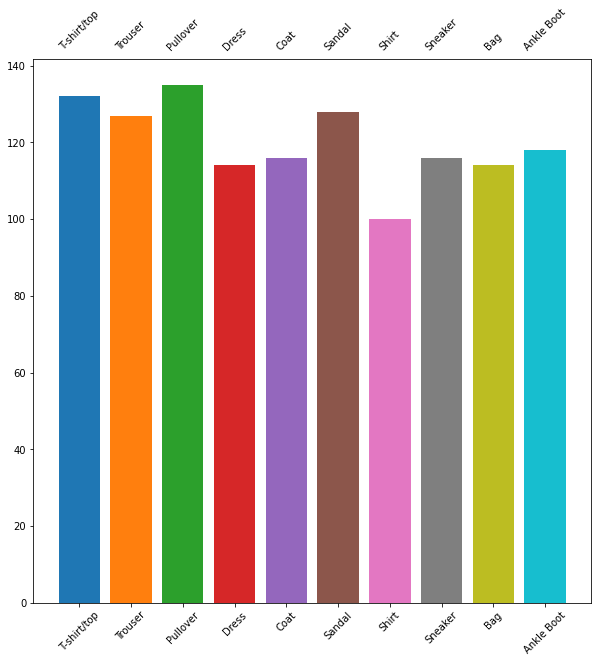

In [ ]:
plot_distribution(validation_distribution)

In [ ]:
# Distribution of the test data
test_distribution = get_distribution_of_classes(test_data, TEST_DATA_LENGTH)
print_distribution_of_classes(test_distribution)

T-shirt/top :   1000
Trouser     :   1000
Pullover    :   1000
Dress       :   1000
Coat        :   1000
Sandal      :   1000
Shirt       :   1000
Sneaker     :   1000
Bag         :   1000
Ankle Boot  :   1000


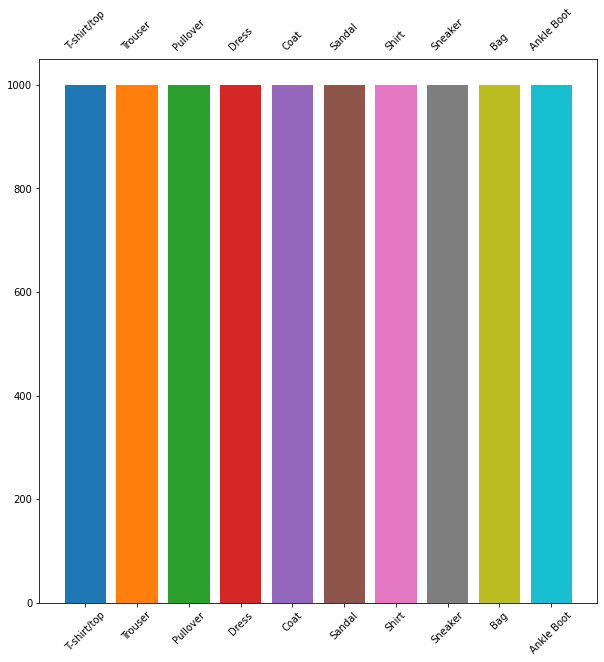

In [ ]:
plot_distribution(test_distribution)

The splited data is almost completely balanced.

# **Image Pre-processing**
image pre-processing will be edited later


In [ ]:
def preprocessing(data):
    """Implements image preprocessing.
Args:
  data: a `PrefetchDataset` representing one of three subsets.
Returns:
  x: a `Tensor` representing image.
  y: a `Tensor` representing label.
    """        
    x = tf.reshape(data["image"], [-1])
    y = data["label"]

    return x, y 

In [ ]:
train_data_pre = train_data.map(preprocessing)
validation_data_pre = validation_data.map(preprocessing)
test_data_pre = test_data.map(preprocessing)

batch_size = 64 
train_data_pre = train_data_pre.batch(batch_size)
validation_data_pre = validation_data_pre.batch(batch_size)
test_data_pre = test_data_pre.batch(batch_size)


# **Base Model Architecture**

In [ ]:
# You are able to modify base_model(), but requirements: 
# 1)Trainable params <= 55,050
# 2)Model contains only 3 fully-connected trainable layers.
def base_model():
  inputs = tf.keras.Input(shape=(784,))
  x = tf.keras.layers.Dense(64, activation='relu')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

model = base_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


TODO: write your own imlementation of the **loss function**, 
i.e. implement **loss_func(y_true, y_pred)** and use it  
instead of tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
def custom_categorical_crossentropy_loss(y, predicted):
  """Implements the crossentropy loss using 'auto'/'sum_over_batch_size' reduction type:
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
Args:
  y: a `Tensor` representing ground truth label.
  predicted: a `Tensor` representing predicted value.
Returns:
  `Tensor` representing crossentropy loss value.
  """ 
  size = y.shape[0]
  return -1 / size * (tf.reduce_sum(y * tf.math.log(predicted + 10 ** -10)))

In [ ]:
@tf.function
def train_step(model_to_be_trained, x, y):
  """Implements gradients computation and weights update.
Args:
  model_to_be_trained: a `tf.Functional` representing built model.
  x: a `Tensor` representing input batch of images.
  y: a `Tensor` representing input batch of labels.
Returns:
  loss: `Tensor` representing crossentropy loss value.
  pred: `Tensor` representing predicted values (batch)
  """ 
  lr = 0.0004
  with tf.GradientTape() as tape:
    pred = model_to_be_trained(x, training=True)
    loss = custom_categorical_crossentropy_loss(y, pred)
    gradients = tape.gradient(loss, model_to_be_trained.trainable_variables)

    new_weights = []
    for w, grad in zip(model_to_be_trained.trainable_variables, gradients):
      new_weights.append(w - lr*grad)

    for v, w in zip (model_to_be_trained.trainable_variables, new_weights):
      v.assign(w)
  return loss, pred

# **Training Procedure**
It's not mentioned that using build-it accuracy metrics prohibited. 
We will use 

```
tf.keras.metrics.CategoricalAccuracy()
```



In [ ]:
def training_loop(model_to_be_trained, train_data, val_data, epoch_num, train_metric, val_metric):
  """Implements custom training loop.
Args:
  model_to_be_trained: a `tf.Functional` representing built model.
  train_data: a `BatchDataset` representing input batch of images and labels for training.
  val_data: a `BatchDataset` representing input batch of images and labels for validation.
  epoch_num: an `int` value representing number of epochs.
  train_metric: a `tf.keras.metrics` value representing accuracy metric for training.
  val_metric: a `tf.keras.metrics` value representing accuracy metric for validation.
Returns:
  `list` of four metrics during training: training loss and accuracy, 
          validation loss and accuracy.
  """ 
  training_loss_history = list()
  validation_loss_history = list()
  training_accuracy_history = list()
  validation_accuracy_history = list()
  for epoch in range(epoch_num):
    print("------------------------------")
    print("epoch {}:".format(epoch))
    training_losses = list()
    for step, (x, y) in enumerate(tqdm(train_data_pre)):

      y = tf.keras.utils.to_categorical(y, 10) 
      loss, prediction = train_step(model_to_be_trained, x, y)
      
      training_losses.append(loss)
      train_acc_metric.update_state(y, prediction)
    
    avg_training_loss_per_epoch = tf.reduce_sum(tf.stack(training_losses)) / len(training_losses)
    training_loss_history.append(avg_training_loss_per_epoch)
    training_accuracy_history.append(train_acc_metric.result().numpy())

    print("Average training loss on epoch #{}: {}".format(epoch, avg_training_loss_per_epoch.numpy()))
    print("Training accuracy on epoch #{}: {}".format(epoch, train_acc_metric.result().numpy()))
    
    validation_losses = list()
    for (x, y) in validation_data_pre:
      y = tf.keras.utils.to_categorical(y, 10) 
      prediction = model_to_be_trained(x, training=False)

      loss = custom_categorical_crossentropy_loss(y, prediction)
      validation_losses.append(loss)
      val_acc_metric.update_state(y, prediction)
      
    avg_validation_loss_per_epoch = tf.reduce_sum(tf.stack(validation_losses)) / len(validation_losses)
    validation_loss_history.append(avg_validation_loss_per_epoch)
    validation_accuracy_history.append(val_acc_metric.result().numpy())

    print("Average validation loss on epoch #{}: {}".format(epoch, avg_validation_loss_per_epoch.numpy()))
    print("Validation accuracy on epoch #{}: {}".format(epoch, val_acc_metric.result().numpy()))

  return [training_loss_history, validation_loss_history, 
          training_accuracy_history, validation_accuracy_history]

In [ ]:
EPOCHS_NUM = 30
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history = training_loop(model, train_data_pre, validation_data_pre, EPOCHS_NUM, train_acc_metric, val_acc_metric)

------------------------------
epoch 0:


100%|██████████| 919/919 [00:04<00:00, 219.54it/s]


Average training loss on epoch #0: 0.5393186807632446
Training accuracy on epoch #0: 0.8136734962463379
Average validation loss on epoch #0: 0.55312579870224
Validation accuracy on epoch #0: 0.8100000023841858
------------------------------
epoch 1:


100%|██████████| 919/919 [00:05<00:00, 179.42it/s]


Average training loss on epoch #1: 0.5232719779014587
Training accuracy on epoch #1: 0.8161224722862244
Average validation loss on epoch #1: 0.5364145040512085
Validation accuracy on epoch #1: 0.809166669845581
------------------------------
epoch 2:


100%|██████████| 919/919 [00:05<00:00, 178.71it/s]


Average training loss on epoch #2: 0.5103322863578796
Training accuracy on epoch #2: 0.8175169825553894
Average validation loss on epoch #2: 0.534000813961029
Validation accuracy on epoch #2: 0.8088889122009277
------------------------------
epoch 3:


100%|██████████| 919/919 [00:05<00:00, 179.47it/s]


Average training loss on epoch #3: 0.4987427294254303
Training accuracy on epoch #3: 0.8192134499549866
Average validation loss on epoch #3: 0.5238766670227051
Validation accuracy on epoch #3: 0.8100000023841858
------------------------------
epoch 4:


100%|██████████| 919/919 [00:05<00:00, 179.36it/s]


Average training loss on epoch #4: 0.4887990951538086
Training accuracy on epoch #4: 0.8209353685379028
Average validation loss on epoch #4: 0.5165307521820068
Validation accuracy on epoch #4: 0.8115000128746033
------------------------------
epoch 5:


100%|██████████| 919/919 [00:04<00:00, 228.42it/s]


Average training loss on epoch #5: 0.4794851243495941
Training accuracy on epoch #5: 0.8223441243171692
Average validation loss on epoch #5: 0.511643648147583
Validation accuracy on epoch #5: 0.8123611211776733
------------------------------
epoch 6:


100%|██████████| 919/919 [00:05<00:00, 179.40it/s]


Average training loss on epoch #6: 0.4718983471393585
Training accuracy on epoch #6: 0.8237074613571167
Average validation loss on epoch #6: 0.5059621930122375
Validation accuracy on epoch #6: 0.8133333325386047
------------------------------
epoch 7:


100%|██████████| 919/919 [00:04<00:00, 227.54it/s]


Average training loss on epoch #7: 0.4640845060348511
Training accuracy on epoch #7: 0.8250489234924316
Average validation loss on epoch #7: 0.5013917088508606
Validation accuracy on epoch #7: 0.8145833611488342
------------------------------
epoch 8:


100%|██████████| 919/919 [00:04<00:00, 225.52it/s]


Average training loss on epoch #8: 0.4569507837295532
Training accuracy on epoch #8: 0.8263643383979797
Average validation loss on epoch #8: 0.49880871176719666
Validation accuracy on epoch #8: 0.8155555725097656
------------------------------
epoch 9:


100%|██████████| 919/919 [00:05<00:00, 179.26it/s]


Average training loss on epoch #9: 0.4513168931007385
Training accuracy on epoch #9: 0.8275952339172363
Average validation loss on epoch #9: 0.494050532579422
Validation accuracy on epoch #9: 0.8164166808128357
------------------------------
epoch 10:


100%|██████████| 919/919 [00:03<00:00, 235.03it/s]


Average training loss on epoch #10: 0.4451947510242462
Training accuracy on epoch #10: 0.8287739753723145
Average validation loss on epoch #10: 0.4860767424106598
Validation accuracy on epoch #10: 0.8178030252456665
------------------------------
epoch 11:


100%|██████████| 919/919 [00:04<00:00, 229.25it/s]


Average training loss on epoch #11: 0.43998074531555176
Training accuracy on epoch #11: 0.8299291133880615
Average validation loss on epoch #11: 0.48491743206977844
Validation accuracy on epoch #11: 0.8186110854148865
------------------------------
epoch 12:


100%|██████████| 919/919 [00:03<00:00, 235.26it/s]


Average training loss on epoch #12: 0.4345504939556122
Training accuracy on epoch #12: 0.8310047388076782
Average validation loss on epoch #12: 0.4793270528316498
Validation accuracy on epoch #12: 0.8196794986724854
------------------------------
epoch 13:


100%|██████████| 919/919 [00:03<00:00, 235.66it/s]


Average training loss on epoch #13: 0.42987725138664246
Training accuracy on epoch #13: 0.8319982886314392
Average validation loss on epoch #13: 0.4775213897228241
Validation accuracy on epoch #13: 0.8207142949104309
------------------------------
epoch 14:


100%|██████████| 919/919 [00:05<00:00, 179.42it/s]


Average training loss on epoch #14: 0.4258106052875519
Training accuracy on epoch #14: 0.8329365253448486
Average validation loss on epoch #14: 0.47442129254341125
Validation accuracy on epoch #14: 0.8215000033378601
------------------------------
epoch 15:


100%|██████████| 919/919 [00:05<00:00, 179.35it/s]


Average training loss on epoch #15: 0.42158663272857666
Training accuracy on epoch #15: 0.8338233232498169
Average validation loss on epoch #15: 0.4672764837741852
Validation accuracy on epoch #15: 0.8222395777702332
------------------------------
epoch 16:


100%|██████████| 919/919 [00:05<00:00, 178.95it/s]


Average training loss on epoch #16: 0.4176521897315979
Training accuracy on epoch #16: 0.8347159028053284
Average validation loss on epoch #16: 0.46664515137672424
Validation accuracy on epoch #16: 0.8230392336845398
------------------------------
epoch 17:


100%|██████████| 919/919 [00:04<00:00, 198.16it/s]


Average training loss on epoch #17: 0.41412678360939026
Training accuracy on epoch #17: 0.8355215191841125
Average validation loss on epoch #17: 0.46270209550857544
Validation accuracy on epoch #17: 0.823796272277832
------------------------------
epoch 18:


100%|██████████| 919/919 [00:03<00:00, 234.85it/s]


Average training loss on epoch #18: 0.4105011820793152
Training accuracy on epoch #18: 0.8363256454467773
Average validation loss on epoch #18: 0.4636010527610779
Validation accuracy on epoch #18: 0.8244736790657043
------------------------------
epoch 19:


100%|██████████| 919/919 [00:05<00:00, 179.42it/s]


Average training loss on epoch #19: 0.4072458744049072
Training accuracy on epoch #19: 0.8371122479438782
Average validation loss on epoch #19: 0.45735058188438416
Validation accuracy on epoch #19: 0.8252500295639038
------------------------------
epoch 20:


100%|██████████| 919/919 [00:03<00:00, 233.32it/s]


Average training loss on epoch #20: 0.40418973565101624
Training accuracy on epoch #20: 0.8379040956497192
Average validation loss on epoch #20: 0.45334434509277344
Validation accuracy on epoch #20: 0.825952410697937
------------------------------
epoch 21:


100%|██████████| 919/919 [00:05<00:00, 179.33it/s]


Average training loss on epoch #21: 0.4010045826435089
Training accuracy on epoch #21: 0.8386495113372803
Average validation loss on epoch #21: 0.4518028199672699
Validation accuracy on epoch #21: 0.826590895652771
------------------------------
epoch 22:


100%|██████████| 919/919 [00:03<00:00, 230.11it/s]


Average training loss on epoch #22: 0.3981976807117462
Training accuracy on epoch #22: 0.8393884897232056
Average validation loss on epoch #22: 0.44964084029197693
Validation accuracy on epoch #22: 0.8270652294158936
------------------------------
epoch 23:


100%|██████████| 919/919 [00:05<00:00, 179.38it/s]


Average training loss on epoch #23: 0.395679771900177
Training accuracy on epoch #23: 0.8400899767875671
Average validation loss on epoch #23: 0.4472438395023346
Validation accuracy on epoch #23: 0.8275347352027893
------------------------------
epoch 24:


100%|██████████| 919/919 [00:04<00:00, 184.46it/s]


Average training loss on epoch #24: 0.3929291069507599
Training accuracy on epoch #24: 0.8407993316650391
Average validation loss on epoch #24: 0.44477328658103943
Validation accuracy on epoch #24: 0.8279333114624023
------------------------------
epoch 25:


100%|██████████| 919/919 [00:03<00:00, 231.67it/s]


Average training loss on epoch #25: 0.3903093636035919
Training accuracy on epoch #25: 0.841476321220398
Average validation loss on epoch #25: 0.44399672746658325
Validation accuracy on epoch #25: 0.82833331823349
------------------------------
epoch 26:


100%|██████████| 919/919 [00:03<00:00, 230.49it/s]


Average training loss on epoch #26: 0.387885183095932
Training accuracy on epoch #26: 0.8421258330345154
Average validation loss on epoch #26: 0.4421646296977997
Validation accuracy on epoch #26: 0.8287037014961243
------------------------------
epoch 27:


100%|██████████| 919/919 [00:03<00:00, 233.42it/s]


Average training loss on epoch #27: 0.38564950227737427
Training accuracy on epoch #27: 0.8427550792694092
Average validation loss on epoch #27: 0.4402843415737152
Validation accuracy on epoch #27: 0.8291666507720947
------------------------------
epoch 28:


100%|██████████| 919/919 [00:05<00:00, 179.40it/s]


Average training loss on epoch #28: 0.3831375241279602
Training accuracy on epoch #28: 0.8433796763420105
Average validation loss on epoch #28: 0.4380563497543335
Validation accuracy on epoch #28: 0.8294540047645569
------------------------------
epoch 29:


100%|██████████| 919/919 [00:03<00:00, 230.45it/s]


Average training loss on epoch #29: 0.3809538781642914
Training accuracy on epoch #29: 0.8439795970916748
Average validation loss on epoch #29: 0.4378427267074585
Validation accuracy on epoch #29: 0.8296666741371155


In [ ]:
def plot_training_history(epoch_num, training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history):
  """Implements custom training loop.
Args:
  training_loss_history: a `list` representing saved average training loss values per epoch.
  validation_loss_history: a `list` representing saved average validation loss values per epoch.
  training_accuracy_history: a `list` representing saved training accuracy per epoch.
  validation_accuracy_history: a `list` representing saved validation accuracy per epoch.
  """  
  fig = plt.figure(figsize=(12, 9))

  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  
  ax1.plot(range(epoch_num), training_loss_history, label='training_loss')
  ax1.plot(range(epoch_num), validation_loss_history, label='validation_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Cross-entropy loss')
  ax1.set_title('Training VS Validation loss')
  ax1.legend()

  ax2.plot(range(epoch_num), training_accuracy_history, label='training_accuracy')
  ax2.plot(range(epoch_num), validation_accuracy_history, label='validation_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Categorical accuracy')
  ax2.set_title('Training VS Validation accuracy')
  ax2.legend()

  plt.show()

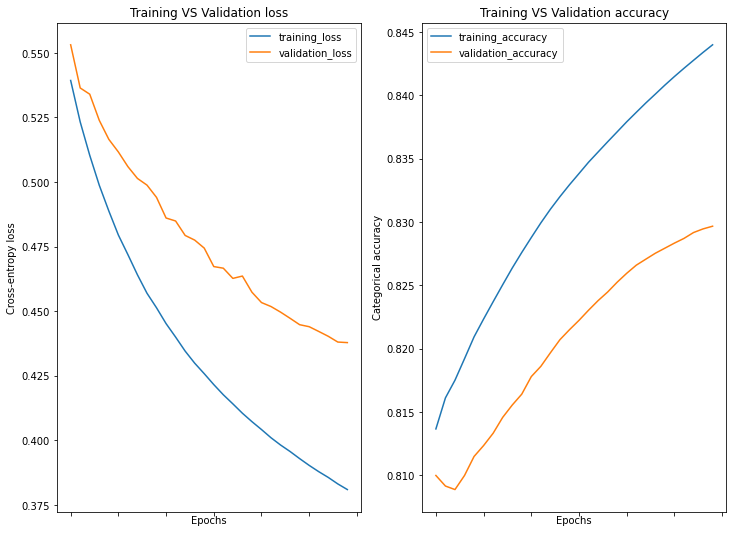

In [ ]:
plot_training_history(EPOCHS_NUM, training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history)

# TO DO : calculate accuracy on the test dataset 'test_data_pre'

In [ ]:
def evaluation_loop(input_model, test_data, test_metric):
  """Implements evaluation loop for checking accuracy of the trained model.
Args:
  input_model: a `tf.Functional` representing trained model.
  test_data: a `BatchDataset` representing input batch of images and labels for testing.
  test_metric: a `tf.keras.metrics` value representing accuracy metric for testing.
Returns:
  A `numpy.float32` value representing accuracy score
  """  
  for (x, y) in test_data:
    pred = input_model(x)
    y = tf.keras.utils.to_categorical(y, 10)
    test_metric.update_state(y, pred)
  return test_metric.result().numpy()


In [ ]:
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()

print("Test accuracy of the base model: {}".format(evaluation_loop(model, test_data_pre, test_acc_metric)))

  

Test accuracy of the base model: 0.8210999965667725


# **Ways to improve model**
We have to get a higher accuracy value. 
For that goal we will: 

*   Improve data preparation
*   Add image augmentations
*   Improve model's architecture
*   Add learning rate scheduler
*   Implement Adam optimizer which is the best among the adaptive optimizers in most of the cases











# **Advanced data preparation**

In [ ]:
# As we can see (from the plots with colorbars) the pixel values vary between 0 and 255.
# We should scale them to the range [0, 1]
def preprocessing(data):
    """Implements image preprocessing.
Args:
  data: a `PrefetchDataset` representing one of three subsets.
Returns:
  x: a `Tensor` representing image.
  y: a `Tensor` representing label.
    """       
    # resize image from 28x28x1 to 24x24x1
    x = tf.image.resize(data["image"], [24, 24]) 
    # scaling one-dimensional array to [0, 1] range
    x = tf.cast(x, tf.float32) / 255.0
    
    y = tf.cast(data["label"], tf.float32)

    return x, y 

For training model on Fashion MNIST dataset two data augmentation techniques were used:

*   Horizontal flip (left to right)
*   Random Rotation (angle in range [-10, 10] degrees)



In [ ]:
class RandomFlipOnProbability(tf.keras.layers.Layer):
  """
  Implementation of a custom data augmentation that flips image horizontally 
  (left to right) on a specific probability.
  """
  def __init__(self, probability=0.1, **kwargs):
    super().__init__(**kwargs)
    self.probability = probability
    self.layer = tf.keras.layers.RandomFlip(mode='horizontal')
  
  def __call__(self, x):
    return tf.cond(tf.less(tf.random.uniform([]), self.probability), lambda: self.layer(x), lambda: x)

class RandomRotationOnProbability(tf.keras.layers.Layer):
  """
  Implementation of a custom data augmentation that rotates image an angle 
  on a specific probability.
  """
  def __init__(self, probability=0.1, **kwargs):
    super().__init__(**kwargs)
    self.probability = probability
    # factor - a tuple of size 2 representing lower and upper bound for rotating clockwise and counter-clockwise, fraction of 2 Pi.
    self.layer = tf.keras.layers.RandomRotation(factor=(-0.055, 0.055), interpolation='bilinear')
  
  def __call__(self, x):
    return tf.cond(tf.less(tf.random.uniform([]), self.probability), lambda: self.layer(x), lambda: x)

data_augmentation = tf.keras.Sequential([
    RandomFlipOnProbability(probability=0.2),
    RandomRotationOnProbability(probability=0.1)
])

In [ ]:
train_data_pre = train_data.map(preprocessing)
validation_data_pre = validation_data.map(preprocessing)
test_data_pre = test_data.map(preprocessing)
batch_size = 24
# adding shuffling
train_data_pre = train_data_pre.shuffle(batch_size).batch(batch_size)
validation_data_pre = validation_data_pre.shuffle(batch_size).batch(batch_size)
test_data_pre = test_data_pre.shuffle(batch_size).batch(batch_size)

In [ ]:
train_data_pre_aug = train_data_pre.map(lambda x, y: (data_augmentation(x), y))
validation_data_pre_aug = validation_data_pre.map(lambda x, y: (data_augmentation(x), y))

# Base Model Improving
To avoid overfitting we will use dropout regularization, i.e. add some Dropout layers.

And also we will add `kernel_regularizer`, regularizer that applies both L1 and L2 regularization penalties for first two Dense layers.

In addition we will add ```tf.keras.layers.BatchNormalization``` for [0,1]
input normalization



In [ ]:
# You are able to modify base_model(), but requirements: 
# 1)Trainable params <= 55,050
# 2)Model contains only 3 fully-connected trainable layers.
def improved_base_model():
  inputs = tf.keras.Input(shape=(24,24,))
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(84, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.05, l2=0.05))(x)
  x = tf.keras.layers.BatchNormalization(trainable=False)(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  
  x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.05, l2=0.05))(x)
  x = tf.keras.layers.BatchNormalization(trainable=False)(x)
  x = tf.keras.layers.Dropout(0.175)(x)
  
  outputs = tf.keras.layers.Dense(10, 
                                  activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

improved_model = improved_base_model()
improved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24)]          0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 84)                48468     
                                                                 
 batch_normalization (BatchN  (None, 84)               336       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                5440      
                                                             

# **Learning Rate Scheduler**
The Cosine Learning Rate Scheduler was implemented.

In [ ]:
class CosineScheduler:
  """
  Implementation of cosine scheduler for learning rate decay during training phase.
  """
  def __init__(self, max_update, base_lr=0.01, final_lr=0,
              warmup_steps=0, warmup_begin_lr=0):
    
    self.base_lr_orig = base_lr
    self.max_update = max_update
    self.final_lr = final_lr
    self.warmup_steps = warmup_steps
    self.warmup_begin_lr = warmup_begin_lr
    self.max_steps = self.max_update - self.warmup_steps

  def get_warmup_lr(self, epoch):
    """
    Method that implements warm-up leraning rate value, if warmup_steps parameter 
    is not zero.
  Args:
    epoch: an epoch number.
  Returns:
    learning rate value.
    """
    increase = (self.base_lr_orig - self.warmup_begin_lr) \
                    * float(epoch) / float(self.warmup_steps)
    return self.warmup_begin_lr + increase

  def __call__(self, epoch):
      if epoch < self.warmup_steps:
          return self.get_warmup_lr(epoch)
      if epoch <= self.max_update:
          self.base_lr = self.final_lr + (
              self.base_lr_orig - self.final_lr) * (1 + math.cos(
              math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
      return self.base_lr

In [ ]:
scheduler = CosineScheduler(120, warmup_steps=0, base_lr=0.0005, final_lr=0.000005)

# **Adam optimizer implementation**

In [ ]:
class CustomAdamOptimizer(tf.keras.optimizers.Optimizer):
  """
  Implementation of the Adam optimizer using inheritance from tf.keras.optimizers.Optimizer
  """
  
  def __init__(self, learning_rate=.001, beta_1=.9, beta_2=.999, epsilon=1e-8, 
               name='Adam', **kwargs):
    super().__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or tf.keras.backend.epsilon()
  
  def _create_slots(self, var_list):
    """Create all slots needed by the variables.
    Args:
      var_list: A list of `Variable` objects.
    """
    for var in var_list:
      self.add_slot(var, 'm')
      self.add_slot(var, 'v')
  

  def _resource_apply_dense(self, grad, var):
    """Add ops to apply dense gradients to the variable `var`.
      Perform optimization step.
    Args:
      grad: a `Tensor` representing the gradient.
      var: a `Tensor` of dtype `resource` which points to the variable
       to be updated.
    Returns:
      An `Operation` which updates the value of the variable.
    """
    dtype = var.dtype.base_dtype
    t = tf.cast(self.iterations + 1, dtype)
    lr = self._decayed_lr(dtype)
    beta_1 = self._get_hyper('beta_1', dtype)
    beta_2 = self._get_hyper('beta_2', dtype)
    epsilon = tf.convert_to_tensor(self.epsilon, dtype)

    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')

    m = m.assign(beta_1 * m + (1. - beta_1) * grad)
    v = v.assign(beta_2 * v + (1. - beta_2) * tf.square(grad))

    lr = lr * tf.sqrt(1 - tf.pow(beta_2, t)) / (1 - tf.pow(beta_1, t))
    update = -lr * m / (tf.sqrt(v) + epsilon)
    var_update = var.assign_add(update)
    updates = [var_update, m, v]
    return tf.group(*updates)

In [ ]:
optimizer = CustomAdamOptimizer(learning_rate=0.0005)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(model_to_be_trained, x, y):
  """Implements gradients computation and weights update.
Args:
  model_to_be_trained: a `tf.Functional` representing built model.
  x: a `Tensor` representing input batch of images.
  y: a `Tensor` representing input batch of labels.
Returns:
  loss: `Tensor` representing crossentropy loss value.
  pred: `Tensor` representing predicted values (batch)
  """ 
  with tf.GradientTape() as tape:
    prediction = model_to_be_trained(x, training=True)

    loss = custom_categorical_crossentropy_loss(y, prediction)

    gradients = tape.gradient(loss, model_to_be_trained.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model_to_be_trained.trainable_variables))
  
  return loss, prediction

# **Training Procedure**

Updated training loop using learning rate decay:


In [ ]:
def training_loop(model_to_be_trained, train_data, val_data, epoch_num, train_metric, val_metric, lr_scheduler):
  """Implements custom training loop.
Args:
  model_to_be_trained: a `tf.Functional` representing built model.
  train_data: a `BatchDataset` representing input batch of images and labels for training.
  val_data: a `BatchDataset` representing input batch of images and labels for validation.
  epoch_num: an `int` value representing number of epochs.
  train_metric: a `tf.keras.metrics` value representing accuracy metric for training.
  val_metric: a `tf.keras.metrics` value representing accuracy metric for validation.
Returns:
  `list` of four metrics during training: training loss and accuracy, 
          validation loss and accuracy.
  """ 
  training_loss_history = list()
  validation_loss_history = list()
  training_accuracy_history = list()
  validation_accuracy_history = list()


  for epoch in range(epoch_num):
    optimizer.learning_rate = lr_scheduler(epoch)

    print("------------------------------")
    print("epoch {}:".format(epoch))
    training_losses = list()
    for step, (x, y) in enumerate(tqdm(train_data_pre)):

      y = tf.keras.utils.to_categorical(y, 10) 
      loss, prediction = train_step(model_to_be_trained, x, y)
      
      training_losses.append(loss)
      train_acc_metric.update_state(y, prediction)
    
    avg_training_loss_per_epoch = tf.reduce_sum(tf.stack(training_losses)) / len(training_losses)
    training_loss_history.append(avg_training_loss_per_epoch)
    training_accuracy_history.append(train_acc_metric.result().numpy())

    print("Average training loss on epoch #{}: {}".format(epoch, avg_training_loss_per_epoch.numpy()))
    print("Training accuracy on epoch #{}: {}".format(epoch, train_acc_metric.result().numpy()))
    
    validation_losses = list()
    for (x, y) in validation_data_pre:
      y = tf.keras.utils.to_categorical(y, 10) 
      prediction = model_to_be_trained(x, training=False)

      loss = custom_categorical_crossentropy_loss(y, prediction)
      validation_losses.append(loss)
      val_acc_metric.update_state(y, prediction)
      
    avg_validation_loss_per_epoch = tf.reduce_sum(tf.stack(validation_losses)) / len(validation_losses)
    validation_loss_history.append(avg_validation_loss_per_epoch)
    validation_accuracy_history.append(val_acc_metric.result().numpy())

    print("Average validation loss on epoch #{}: {}".format(epoch, avg_validation_loss_per_epoch.numpy()))
    print("Validation accuracy on epoch #{}: {}".format(epoch, val_acc_metric.result().numpy()))
    validation_data_pre.shuffle(batch_size)

  return [training_loss_history, validation_loss_history, 
          training_accuracy_history, validation_accuracy_history]

In [ ]:
EPOCHS_NUM = 120
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history = training_loop(improved_model, train_data_pre_aug, validation_data_pre_aug, EPOCHS_NUM, train_acc_metric, val_acc_metric, scheduler)

------------------------------
epoch 0:


100%|██████████| 2450/2450 [00:12<00:00, 193.91it/s]


Average training loss on epoch #0: 0.653962254524231
Training accuracy on epoch #0: 0.7696938514709473
Average validation loss on epoch #0: 0.39076173305511475
Validation accuracy on epoch #0: 0.8550000190734863
------------------------------
epoch 1:


100%|██████████| 2450/2450 [00:11<00:00, 205.02it/s]


Average training loss on epoch #1: 0.4558684527873993
Training accuracy on epoch #1: 0.8034098744392395
Average validation loss on epoch #1: 0.32999539375305176
Validation accuracy on epoch #1: 0.8666666746139526
------------------------------
epoch 2:


100%|██████████| 2450/2450 [00:12<00:00, 203.95it/s]


Average training loss on epoch #2: 0.4152263104915619
Training accuracy on epoch #2: 0.8191099762916565
Average validation loss on epoch #2: 0.31654679775238037
Validation accuracy on epoch #2: 0.8730555772781372
------------------------------
epoch 3:


100%|██████████| 2450/2450 [00:12<00:00, 188.88it/s]


Average training loss on epoch #3: 0.39047420024871826
Training accuracy on epoch #3: 0.8288435339927673
Average validation loss on epoch #3: 0.30144184827804565
Validation accuracy on epoch #3: 0.8785416483879089
------------------------------
epoch 4:


100%|██████████| 2450/2450 [00:12<00:00, 198.72it/s]


Average training loss on epoch #4: 0.3744406998157501
Training accuracy on epoch #4: 0.8357925415039062
Average validation loss on epoch #4: 0.28797686100006104
Validation accuracy on epoch #4: 0.8821666836738586
------------------------------
epoch 5:


100%|██████████| 2450/2450 [00:13<00:00, 183.80it/s]


Average training loss on epoch #5: 0.36007556319236755
Training accuracy on epoch #5: 0.8412188291549683
Average validation loss on epoch #5: 0.27788928151130676
Validation accuracy on epoch #5: 0.8848611116409302
------------------------------
epoch 6:


100%|██████████| 2450/2450 [00:13<00:00, 179.70it/s]


Average training loss on epoch #6: 0.35292381048202515
Training accuracy on epoch #6: 0.8453644514083862
Average validation loss on epoch #6: 0.27978551387786865
Validation accuracy on epoch #6: 0.8864285945892334
------------------------------
epoch 7:


100%|██████████| 2450/2450 [00:11<00:00, 204.92it/s]


Average training loss on epoch #7: 0.34291040897369385
Training accuracy on epoch #7: 0.8491751551628113
Average validation loss on epoch #7: 0.2808365225791931
Validation accuracy on epoch #7: 0.8878124952316284
------------------------------
epoch 8:


100%|██████████| 2450/2450 [00:11<00:00, 204.78it/s]


Average training loss on epoch #8: 0.3346969783306122
Training accuracy on epoch #8: 0.8522071242332458
Average validation loss on epoch #8: 0.2684932351112366
Validation accuracy on epoch #8: 0.8891666531562805
------------------------------
epoch 9:


100%|██████████| 2450/2450 [00:12<00:00, 204.08it/s]


Average training loss on epoch #9: 0.3294835388660431
Training accuracy on epoch #9: 0.854823112487793
Average validation loss on epoch #9: 0.25865408778190613
Validation accuracy on epoch #9: 0.890500009059906
------------------------------
epoch 10:


100%|██████████| 2450/2450 [00:12<00:00, 203.10it/s]


Average training loss on epoch #10: 0.32405945658683777
Training accuracy on epoch #10: 0.8571969866752625
Average validation loss on epoch #10: 0.2623891234397888
Validation accuracy on epoch #10: 0.8915151357650757
------------------------------
epoch 11:


100%|██████████| 2450/2450 [00:11<00:00, 205.00it/s]


Average training loss on epoch #11: 0.3193809390068054
Training accuracy on epoch #11: 0.8593367338180542
Average validation loss on epoch #11: 0.2594006061553955
Validation accuracy on epoch #11: 0.8930555582046509
------------------------------
epoch 12:


100%|██████████| 2450/2450 [00:12<00:00, 203.96it/s]


Average training loss on epoch #12: 0.3158271014690399
Training accuracy on epoch #12: 0.861177384853363
Average validation loss on epoch #12: 0.24529165029525757
Validation accuracy on epoch #12: 0.8943589925765991
------------------------------
epoch 13:


100%|██████████| 2450/2450 [00:11<00:00, 204.56it/s]


Average training loss on epoch #13: 0.3130418658256531
Training accuracy on epoch #13: 0.8628000617027283
Average validation loss on epoch #13: 0.25414401292800903
Validation accuracy on epoch #13: 0.8951190710067749
------------------------------
epoch 14:


100%|██████████| 2450/2450 [00:12<00:00, 190.86it/s]


Average training loss on epoch #14: 0.3053617775440216
Training accuracy on epoch #14: 0.8643798232078552
Average validation loss on epoch #14: 0.27042725682258606
Validation accuracy on epoch #14: 0.8953889012336731
------------------------------
epoch 15:


100%|██████████| 2450/2450 [00:11<00:00, 204.22it/s]


Average training loss on epoch #15: 0.30395346879959106
Training accuracy on epoch #15: 0.8658067584037781
Average validation loss on epoch #15: 0.2607937157154083
Validation accuracy on epoch #15: 0.8958333134651184
------------------------------
epoch 16:


100%|██████████| 2450/2450 [00:11<00:00, 204.56it/s]


Average training loss on epoch #16: 0.30162903666496277
Training accuracy on epoch #16: 0.8671518564224243
Average validation loss on epoch #16: 0.24983297288417816
Validation accuracy on epoch #16: 0.8962745070457458
------------------------------
epoch 17:


100%|██████████| 2450/2450 [00:12<00:00, 203.33it/s]


Average training loss on epoch #17: 0.2956090271472931
Training accuracy on epoch #17: 0.8683626055717468
Average validation loss on epoch #17: 0.24756166338920593
Validation accuracy on epoch #17: 0.8968518376350403
------------------------------
epoch 18:


100%|██████████| 2450/2450 [00:11<00:00, 204.78it/s]


Average training loss on epoch #18: 0.29153475165367126
Training accuracy on epoch #18: 0.8696123957633972
Average validation loss on epoch #18: 0.25505760312080383
Validation accuracy on epoch #18: 0.8977631330490112
------------------------------
epoch 19:


100%|██████████| 2450/2450 [00:11<00:00, 204.61it/s]


Average training loss on epoch #19: 0.2898802161216736
Training accuracy on epoch #19: 0.8707525730133057
Average validation loss on epoch #19: 0.2449205368757248
Validation accuracy on epoch #19: 0.8982916474342346
------------------------------
epoch 20:


100%|██████████| 2450/2450 [00:11<00:00, 205.34it/s]


Average training loss on epoch #20: 0.28596633672714233
Training accuracy on epoch #20: 0.8718003034591675
Average validation loss on epoch #20: 0.24946361780166626
Validation accuracy on epoch #20: 0.8990476131439209
------------------------------
epoch 21:


100%|██████████| 2450/2450 [00:12<00:00, 190.83it/s]


Average training loss on epoch #21: 0.28346025943756104
Training accuracy on epoch #21: 0.872830867767334
Average validation loss on epoch #21: 0.25400546193122864
Validation accuracy on epoch #21: 0.8992045521736145
------------------------------
epoch 22:


100%|██████████| 2450/2450 [00:11<00:00, 204.57it/s]


Average training loss on epoch #22: 0.2811996638774872
Training accuracy on epoch #22: 0.8738301992416382
Average validation loss on epoch #22: 0.24728214740753174
Validation accuracy on epoch #22: 0.8997101187705994
------------------------------
epoch 23:


100%|██████████| 2450/2450 [00:12<00:00, 203.25it/s]


Average training loss on epoch #23: 0.2788149118423462
Training accuracy on epoch #23: 0.8747314214706421
Average validation loss on epoch #23: 0.24955624341964722
Validation accuracy on epoch #23: 0.8999652862548828
------------------------------
epoch 24:


100%|██████████| 2450/2450 [00:12<00:00, 203.31it/s]


Average training loss on epoch #24: 0.2751798629760742
Training accuracy on epoch #24: 0.8756163120269775
Average validation loss on epoch #24: 0.24639499187469482
Validation accuracy on epoch #24: 0.9002333283424377
------------------------------
epoch 25:


100%|██████████| 2450/2450 [00:12<00:00, 203.35it/s]


Average training loss on epoch #25: 0.275077760219574
Training accuracy on epoch #25: 0.8764285445213318
Average validation loss on epoch #25: 0.25487270951271057
Validation accuracy on epoch #25: 0.9005769491195679
------------------------------
epoch 26:


100%|██████████| 2450/2450 [00:11<00:00, 205.25it/s]


Average training loss on epoch #26: 0.2714197635650635
Training accuracy on epoch #26: 0.8772455453872681
Average validation loss on epoch #26: 0.24072694778442383
Validation accuracy on epoch #26: 0.9009259343147278
------------------------------
epoch 27:


100%|██████████| 2450/2450 [00:11<00:00, 204.22it/s]


Average training loss on epoch #27: 0.26879724860191345
Training accuracy on epoch #27: 0.8780636787414551
Average validation loss on epoch #27: 0.24754127860069275
Validation accuracy on epoch #27: 0.901190459728241
------------------------------
epoch 28:


100%|██████████| 2450/2450 [00:13<00:00, 187.70it/s]


Average training loss on epoch #28: 0.26699668169021606
Training accuracy on epoch #28: 0.878844141960144
Average validation loss on epoch #28: 0.25572118163108826
Validation accuracy on epoch #28: 0.9017241597175598
------------------------------
epoch 29:


100%|██████████| 2450/2450 [00:12<00:00, 201.77it/s]


Average training loss on epoch #29: 0.265093594789505
Training accuracy on epoch #29: 0.879593551158905
Average validation loss on epoch #29: 0.25202101469039917
Validation accuracy on epoch #29: 0.901888906955719
------------------------------
epoch 30:


100%|██████████| 2450/2450 [00:20<00:00, 119.65it/s]


Average training loss on epoch #30: 0.26448097825050354
Training accuracy on epoch #30: 0.8802885413169861
Average validation loss on epoch #30: 0.2492266148328781
Validation accuracy on epoch #30: 0.9022042751312256
------------------------------
epoch 31:


100%|██████████| 2450/2450 [00:12<00:00, 203.69it/s]


Average training loss on epoch #31: 0.263031542301178
Training accuracy on epoch #31: 0.8809645771980286
Average validation loss on epoch #31: 0.2438264638185501
Validation accuracy on epoch #31: 0.9024218916893005
------------------------------
epoch 32:


100%|██████████| 2450/2450 [00:11<00:00, 204.26it/s]


Average training loss on epoch #32: 0.2599412202835083
Training accuracy on epoch #32: 0.8816398978233337
Average validation loss on epoch #32: 0.253047913312912
Validation accuracy on epoch #32: 0.9024999737739563
------------------------------
epoch 33:


100%|██████████| 2450/2450 [00:12<00:00, 203.48it/s]


Average training loss on epoch #33: 0.2573418617248535
Training accuracy on epoch #33: 0.8823249340057373
Average validation loss on epoch #33: 0.25180065631866455
Validation accuracy on epoch #33: 0.9026960730552673
------------------------------
epoch 34:


100%|██████████| 2450/2450 [00:12<00:00, 194.72it/s]


Average training loss on epoch #34: 0.2567547857761383
Training accuracy on epoch #34: 0.8829169273376465
Average validation loss on epoch #34: 0.2450069785118103
Validation accuracy on epoch #34: 0.9030952453613281
------------------------------
epoch 35:


100%|██████████| 2450/2450 [00:12<00:00, 203.51it/s]


Average training loss on epoch #35: 0.2557998299598694
Training accuracy on epoch #35: 0.8834868669509888
Average validation loss on epoch #35: 0.25666484236717224
Validation accuracy on epoch #35: 0.9032407402992249
------------------------------
epoch 36:


100%|██████████| 2450/2450 [00:12<00:00, 204.00it/s]


Average training loss on epoch #36: 0.25247427821159363
Training accuracy on epoch #36: 0.8840765953063965
Average validation loss on epoch #36: 0.2581448256969452
Validation accuracy on epoch #36: 0.9034234285354614
------------------------------
epoch 37:


100%|██████████| 2450/2450 [00:12<00:00, 204.10it/s]


Average training loss on epoch #37: 0.25065702199935913
Training accuracy on epoch #37: 0.8846563100814819
Average validation loss on epoch #37: 0.24120767414569855
Validation accuracy on epoch #37: 0.9037938714027405
------------------------------
epoch 38:


100%|██████████| 2450/2450 [00:12<00:00, 203.73it/s]


Average training loss on epoch #38: 0.248467817902565
Training accuracy on epoch #38: 0.8852258920669556
Average validation loss on epoch #38: 0.24413250386714935
Validation accuracy on epoch #38: 0.9041239023208618
------------------------------
epoch 39:


100%|██████████| 2450/2450 [00:12<00:00, 203.42it/s]


Average training loss on epoch #39: 0.24644586443901062
Training accuracy on epoch #39: 0.8857942223548889
Average validation loss on epoch #39: 0.2437693029642105
Validation accuracy on epoch #39: 0.9042500257492065
------------------------------
epoch 40:


100%|██████████| 2450/2450 [00:12<00:00, 201.74it/s]


Average training loss on epoch #40: 0.24771927297115326
Training accuracy on epoch #40: 0.8863128423690796
Average validation loss on epoch #40: 0.2410033792257309
Validation accuracy on epoch #40: 0.9044308662414551
------------------------------
epoch 41:


100%|██████████| 2450/2450 [00:12<00:00, 202.43it/s]


Average training loss on epoch #41: 0.24551476538181305
Training accuracy on epoch #41: 0.8868468403816223
Average validation loss on epoch #41: 0.2520621120929718
Validation accuracy on epoch #41: 0.9045436382293701
------------------------------
epoch 42:


100%|██████████| 2450/2450 [00:13<00:00, 187.05it/s]


Average training loss on epoch #42: 0.24320614337921143
Training accuracy on epoch #42: 0.8873611688613892
Average validation loss on epoch #42: 0.24613603949546814
Validation accuracy on epoch #42: 0.9047287106513977
------------------------------
epoch 43:


100%|██████████| 2450/2450 [00:12<00:00, 197.98it/s]


Average training loss on epoch #43: 0.2424672394990921
Training accuracy on epoch #43: 0.8878815174102783
Average validation loss on epoch #43: 0.2513042986392975
Validation accuracy on epoch #43: 0.9048295617103577
------------------------------
epoch 44:


100%|██████████| 2450/2450 [00:12<00:00, 202.53it/s]


Average training loss on epoch #44: 0.24171549081802368
Training accuracy on epoch #44: 0.888364315032959
Average validation loss on epoch #44: 0.24168354272842407
Validation accuracy on epoch #44: 0.905055582523346
------------------------------
epoch 45:


100%|██████████| 2450/2450 [00:11<00:00, 204.97it/s]


Average training loss on epoch #45: 0.24112561345100403
Training accuracy on epoch #45: 0.888853132724762
Average validation loss on epoch #45: 0.25657621026039124
Validation accuracy on epoch #45: 0.9051086902618408
------------------------------
epoch 46:


100%|██████████| 2450/2450 [00:11<00:00, 204.93it/s]


Average training loss on epoch #46: 0.2371324896812439
Training accuracy on epoch #46: 0.8893378376960754
Average validation loss on epoch #46: 0.24469298124313354
Validation accuracy on epoch #46: 0.9053546190261841
------------------------------
epoch 47:


100%|██████████| 2450/2450 [00:11<00:00, 204.33it/s]


Average training loss on epoch #47: 0.23796232044696808
Training accuracy on epoch #47: 0.8898005485534668
Average validation loss on epoch #47: 0.23941195011138916
Validation accuracy on epoch #47: 0.9055555462837219
------------------------------
epoch 48:


100%|██████████| 2450/2450 [00:12<00:00, 202.34it/s]


Average training loss on epoch #48: 0.23447467386722565
Training accuracy on epoch #48: 0.8902564644813538
Average validation loss on epoch #48: 0.24640655517578125
Validation accuracy on epoch #48: 0.9057313203811646
------------------------------
epoch 49:


100%|██████████| 2450/2450 [00:12<00:00, 190.23it/s]


Average training loss on epoch #49: 0.2336331158876419
Training accuracy on epoch #49: 0.890706479549408
Average validation loss on epoch #49: 0.24799694120883942
Validation accuracy on epoch #49: 0.9058499932289124
------------------------------
epoch 50:


100%|██████████| 2450/2450 [00:11<00:00, 204.47it/s]


Average training loss on epoch #50: 0.23200808465480804
Training accuracy on epoch #50: 0.8911461234092712
Average validation loss on epoch #50: 0.24105127155780792
Validation accuracy on epoch #50: 0.9060784578323364
------------------------------
epoch 51:


100%|██████████| 2450/2450 [00:12<00:00, 203.69it/s]


Average training loss on epoch #51: 0.230772003531456
Training accuracy on epoch #51: 0.8915518522262573
Average validation loss on epoch #51: 0.24905717372894287
Validation accuracy on epoch #51: 0.9062339663505554
------------------------------
epoch 52:


100%|██████████| 2450/2450 [00:12<00:00, 199.41it/s]


Average training loss on epoch #52: 0.23079650104045868
Training accuracy on epoch #52: 0.8919628262519836
Average validation loss on epoch #52: 0.2515822649002075
Validation accuracy on epoch #52: 0.9063836336135864
------------------------------
epoch 53:


100%|██████████| 2450/2450 [00:12<00:00, 201.65it/s]


Average training loss on epoch #53: 0.22821523249149323
Training accuracy on epoch #53: 0.892377495765686
Average validation loss on epoch #53: 0.25339430570602417
Validation accuracy on epoch #53: 0.9064660668373108
------------------------------
epoch 54:


100%|██████████| 2450/2450 [00:12<00:00, 203.73it/s]


Average training loss on epoch #54: 0.2276482731103897
Training accuracy on epoch #54: 0.8927792310714722
Average validation loss on epoch #54: 0.2504779100418091
Validation accuracy on epoch #54: 0.9065909385681152
------------------------------
epoch 55:


100%|██████████| 2450/2450 [00:12<00:00, 203.69it/s]


Average training loss on epoch #55: 0.22660109400749207
Training accuracy on epoch #55: 0.893161416053772
Average validation loss on epoch #55: 0.24569880962371826
Validation accuracy on epoch #55: 0.9066517949104309
------------------------------
epoch 56:


100%|██████████| 2450/2450 [00:12<00:00, 190.74it/s]


Average training loss on epoch #56: 0.22439472377300262
Training accuracy on epoch #56: 0.8935427665710449
Average validation loss on epoch #56: 0.252511203289032
Validation accuracy on epoch #56: 0.906798243522644
------------------------------
epoch 57:


100%|██████████| 2450/2450 [00:12<00:00, 203.93it/s]


Average training loss on epoch #57: 0.222244530916214
Training accuracy on epoch #57: 0.8939312100410461
Average validation loss on epoch #57: 0.24989400804042816
Validation accuracy on epoch #57: 0.9069540500640869
------------------------------
epoch 58:


100%|██████████| 2450/2450 [00:12<00:00, 203.53it/s]


Average training loss on epoch #58: 0.22204597294330597
Training accuracy on epoch #58: 0.8943223357200623
Average validation loss on epoch #58: 0.2542274296283722
Validation accuracy on epoch #58: 0.9071186184883118
------------------------------
epoch 59:


100%|██████████| 2450/2450 [00:12<00:00, 204.08it/s]


Average training loss on epoch #59: 0.22043487429618835
Training accuracy on epoch #59: 0.8947117328643799
Average validation loss on epoch #59: 0.26136425137519836
Validation accuracy on epoch #59: 0.9071527719497681
------------------------------
epoch 60:


100%|██████████| 2450/2450 [00:12<00:00, 204.06it/s]


Average training loss on epoch #60: 0.2210111916065216
Training accuracy on epoch #60: 0.895063579082489
Average validation loss on epoch #60: 0.2498493194580078
Validation accuracy on epoch #60: 0.9073360562324524
------------------------------
epoch 61:


100%|██████████| 2450/2450 [00:12<00:00, 203.57it/s]


Average training loss on epoch #61: 0.21785280108451843
Training accuracy on epoch #61: 0.8954290151596069
Average validation loss on epoch #61: 0.24903219938278198
Validation accuracy on epoch #61: 0.9074059128761292
------------------------------
epoch 62:


100%|██████████| 2450/2450 [00:12<00:00, 204.09it/s]


Average training loss on epoch #62: 0.21809497475624084
Training accuracy on epoch #62: 0.8957658410072327
Average validation loss on epoch #62: 0.2566312551498413
Validation accuracy on epoch #62: 0.9074603319168091
------------------------------
epoch 63:


100%|██████████| 2450/2450 [00:12<00:00, 189.14it/s]


Average training loss on epoch #63: 0.21787744760513306
Training accuracy on epoch #63: 0.8961200714111328
Average validation loss on epoch #63: 0.2492493838071823
Validation accuracy on epoch #63: 0.9074869751930237
------------------------------
epoch 64:


100%|██████████| 2450/2450 [00:11<00:00, 205.31it/s]


Average training loss on epoch #64: 0.21517881751060486
Training accuracy on epoch #64: 0.8964704275131226
Average validation loss on epoch #64: 0.2496562898159027
Validation accuracy on epoch #64: 0.907564103603363
------------------------------
epoch 65:


100%|██████████| 2450/2450 [00:12<00:00, 203.53it/s]


Average training loss on epoch #65: 0.21332509815692902
Training accuracy on epoch #65: 0.8968251347541809
Average validation loss on epoch #65: 0.2408881038427353
Validation accuracy on epoch #65: 0.9076515436172485
------------------------------
epoch 66:


100%|██████████| 2450/2450 [00:12<00:00, 203.74it/s]


Average training loss on epoch #66: 0.21154211461544037
Training accuracy on epoch #66: 0.8971839547157288
Average validation loss on epoch #66: 0.25323647260665894
Validation accuracy on epoch #66: 0.9077114462852478
------------------------------
epoch 67:


100%|██████████| 2450/2450 [00:11<00:00, 204.29it/s]


Average training loss on epoch #67: 0.21147531270980835
Training accuracy on epoch #67: 0.8975175023078918
Average validation loss on epoch #67: 0.2516605257987976
Validation accuracy on epoch #67: 0.9077941179275513
------------------------------
epoch 68:


100%|██████████| 2450/2450 [00:12<00:00, 202.04it/s]


Average training loss on epoch #68: 0.20970794558525085
Training accuracy on epoch #68: 0.8978455662727356
Average validation loss on epoch #68: 0.24981200695037842
Validation accuracy on epoch #68: 0.9079468846321106
------------------------------
epoch 69:


100%|██████████| 2450/2450 [00:12<00:00, 199.36it/s]


Average training loss on epoch #69: 0.20850354433059692
Training accuracy on epoch #69: 0.898176372051239
Average validation loss on epoch #69: 0.2435353845357895
Validation accuracy on epoch #69: 0.908130943775177
------------------------------
epoch 70:


100%|██████████| 2450/2450 [00:20<00:00, 119.63it/s]


Average training loss on epoch #70: 0.20759545266628265
Training accuracy on epoch #70: 0.8985161185264587
Average validation loss on epoch #70: 0.245300754904747
Validation accuracy on epoch #70: 0.9082159399986267
------------------------------
epoch 71:


100%|██████████| 2450/2450 [00:12<00:00, 200.62it/s]


Average training loss on epoch #71: 0.20770137012004852
Training accuracy on epoch #71: 0.8988383412361145
Average validation loss on epoch #71: 0.26091423630714417
Validation accuracy on epoch #71: 0.9081481695175171
------------------------------
epoch 72:


100%|██████████| 2450/2450 [00:12<00:00, 203.54it/s]


Average training loss on epoch #72: 0.20558002591133118
Training accuracy on epoch #72: 0.8991552591323853
Average validation loss on epoch #72: 0.24604257941246033
Validation accuracy on epoch #72: 0.9082648158073425
------------------------------
epoch 73:


100%|██████████| 2450/2450 [00:12<00:00, 201.84it/s]


Average training loss on epoch #73: 0.20564673840999603
Training accuracy on epoch #73: 0.8994660973548889
Average validation loss on epoch #73: 0.24792663753032684
Validation accuracy on epoch #73: 0.9083108305931091
------------------------------
epoch 74:


100%|██████████| 2450/2450 [00:12<00:00, 203.12it/s]


Average training loss on epoch #74: 0.2074686884880066
Training accuracy on epoch #74: 0.8997682332992554
Average validation loss on epoch #74: 0.25229960680007935
Validation accuracy on epoch #74: 0.9083666801452637
------------------------------
epoch 75:


100%|██████████| 2450/2450 [00:12<00:00, 203.58it/s]


Average training loss on epoch #75: 0.20504629611968994
Training accuracy on epoch #75: 0.9000666737556458
Average validation loss on epoch #75: 0.25345221161842346
Validation accuracy on epoch #75: 0.9083552360534668
------------------------------
epoch 76:


100%|██████████| 2450/2450 [00:12<00:00, 200.45it/s]


Average training loss on epoch #76: 0.20351314544677734
Training accuracy on epoch #76: 0.9003560543060303
Average validation loss on epoch #76: 0.25311896204948425
Validation accuracy on epoch #76: 0.9084199070930481
------------------------------
epoch 77:


100%|██████████| 2450/2450 [00:13<00:00, 187.80it/s]


Average training loss on epoch #77: 0.20376668870449066
Training accuracy on epoch #77: 0.9006538987159729
Average validation loss on epoch #77: 0.24886055290699005
Validation accuracy on epoch #77: 0.9084615111351013
------------------------------
epoch 78:


100%|██████████| 2450/2450 [00:12<00:00, 204.07it/s]


Average training loss on epoch #78: 0.20253579318523407
Training accuracy on epoch #78: 0.9009489417076111
Average validation loss on epoch #78: 0.249110147356987
Validation accuracy on epoch #78: 0.9085548520088196
------------------------------
epoch 79:


100%|██████████| 2450/2450 [00:12<00:00, 197.71it/s]


Average training loss on epoch #79: 0.20149467885494232
Training accuracy on epoch #79: 0.9012436270713806
Average validation loss on epoch #79: 0.2470652014017105
Validation accuracy on epoch #79: 0.9086562395095825
------------------------------
epoch 80:


100%|██████████| 2450/2450 [00:12<00:00, 199.84it/s]


Average training loss on epoch #80: 0.20090293884277344
Training accuracy on epoch #80: 0.9015266299247742
Average validation loss on epoch #80: 0.2468235045671463
Validation accuracy on epoch #80: 0.9087139964103699
------------------------------
epoch 81:


100%|██████████| 2450/2450 [00:12<00:00, 200.56it/s]


Average training loss on epoch #81: 0.19982698559761047
Training accuracy on epoch #81: 0.9018045663833618
Average validation loss on epoch #81: 0.2543714642524719
Validation accuracy on epoch #81: 0.9087296724319458
------------------------------
epoch 82:


100%|██████████| 2450/2450 [00:12<00:00, 194.07it/s]


Average training loss on epoch #82: 0.1996885985136032
Training accuracy on epoch #82: 0.9020895957946777
Average validation loss on epoch #82: 0.24145863950252533
Validation accuracy on epoch #82: 0.9088051915168762
------------------------------
epoch 83:


100%|██████████| 2450/2450 [00:12<00:00, 203.22it/s]


Average training loss on epoch #83: 0.19580627977848053
Training accuracy on epoch #83: 0.902368426322937
Average validation loss on epoch #83: 0.24022215604782104
Validation accuracy on epoch #83: 0.9089186787605286
------------------------------
epoch 84:


100%|██████████| 2450/2450 [00:12<00:00, 190.47it/s]


Average training loss on epoch #84: 0.19673986732959747
Training accuracy on epoch #84: 0.9026460647583008
Average validation loss on epoch #84: 0.2470911145210266
Validation accuracy on epoch #84: 0.9090098142623901
------------------------------
epoch 85:


100%|██████████| 2450/2450 [00:12<00:00, 202.83it/s]


Average training loss on epoch #85: 0.19431903958320618
Training accuracy on epoch #85: 0.9029310941696167
Average validation loss on epoch #85: 0.24816648662090302
Validation accuracy on epoch #85: 0.9090794324874878
------------------------------
epoch 86:


100%|██████████| 2450/2450 [00:12<00:00, 202.42it/s]


Average training loss on epoch #86: 0.19727785885334015
Training accuracy on epoch #86: 0.9031913876533508
Average validation loss on epoch #86: 0.2442559003829956
Validation accuracy on epoch #86: 0.9091858267784119
------------------------------
epoch 87:


100%|██████████| 2450/2450 [00:12<00:00, 203.55it/s]


Average training loss on epoch #87: 0.19304487109184265
Training accuracy on epoch #87: 0.9034767150878906
Average validation loss on epoch #87: 0.24260593950748444
Validation accuracy on epoch #87: 0.9092992544174194
------------------------------
epoch 88:


100%|██████████| 2450/2450 [00:12<00:00, 202.91it/s]


Average training loss on epoch #88: 0.19484500586986542
Training accuracy on epoch #88: 0.903742253780365
Average validation loss on epoch #88: 0.24682998657226562
Validation accuracy on epoch #88: 0.9094007611274719
------------------------------
epoch 89:


100%|██████████| 2450/2450 [00:12<00:00, 203.44it/s]


Average training loss on epoch #89: 0.19329820573329926
Training accuracy on epoch #89: 0.9040032029151917
Average validation loss on epoch #89: 0.24867120385169983
Validation accuracy on epoch #89: 0.9095092415809631
------------------------------
epoch 90:


100%|██████████| 2450/2450 [00:12<00:00, 203.67it/s]


Average training loss on epoch #90: 0.19515712559223175
Training accuracy on epoch #90: 0.9042460918426514
Average validation loss on epoch #90: 0.24567924439907074
Validation accuracy on epoch #90: 0.9096153974533081
------------------------------
epoch 91:


100%|██████████| 2450/2450 [00:12<00:00, 189.76it/s]


Average training loss on epoch #91: 0.1910487711429596
Training accuracy on epoch #91: 0.9045101404190063
Average validation loss on epoch #91: 0.24807411432266235
Validation accuracy on epoch #91: 0.909710168838501
------------------------------
epoch 92:


100%|██████████| 2450/2450 [00:12<00:00, 202.61it/s]


Average training loss on epoch #92: 0.19146990776062012
Training accuracy on epoch #92: 0.9047574996948242
Average validation loss on epoch #92: 0.24666191637516022
Validation accuracy on epoch #92: 0.909775972366333
------------------------------
epoch 93:


100%|██████████| 2450/2450 [00:12<00:00, 201.90it/s]


Average training loss on epoch #93: 0.1929900348186493
Training accuracy on epoch #93: 0.9049947261810303
Average validation loss on epoch #93: 0.24499374628067017
Validation accuracy on epoch #93: 0.9098492860794067
------------------------------
epoch 94:


100%|██████████| 2450/2450 [00:12<00:00, 203.35it/s]


Average training loss on epoch #94: 0.19089959561824799
Training accuracy on epoch #94: 0.9052334427833557
Average validation loss on epoch #94: 0.24543815851211548
Validation accuracy on epoch #94: 0.9099122881889343
------------------------------
epoch 95:


100%|██████████| 2450/2450 [00:12<00:00, 203.77it/s]


Average training loss on epoch #95: 0.1902761608362198
Training accuracy on epoch #95: 0.905483603477478
Average validation loss on epoch #95: 0.24536700546741486
Validation accuracy on epoch #95: 0.9099913239479065
------------------------------
epoch 96:


100%|██████████| 2450/2450 [00:12<00:00, 202.82it/s]


Average training loss on epoch #96: 0.18915961682796478
Training accuracy on epoch #96: 0.9057167172431946
Average validation loss on epoch #96: 0.24748793244361877
Validation accuracy on epoch #96: 0.9100601077079773
------------------------------
epoch 97:


100%|██████████| 2450/2450 [00:12<00:00, 202.84it/s]


Average training loss on epoch #97: 0.1901986449956894
Training accuracy on epoch #97: 0.9059464931488037
Average validation loss on epoch #97: 0.2435835599899292
Validation accuracy on epoch #97: 0.9101360440254211
------------------------------
epoch 98:


100%|██████████| 2450/2450 [00:12<00:00, 189.04it/s]


Average training loss on epoch #98: 0.1878861039876938
Training accuracy on epoch #98: 0.9061777591705322
Average validation loss on epoch #98: 0.24635960161685944
Validation accuracy on epoch #98: 0.9102104306221008
------------------------------
epoch 99:


100%|██████████| 2450/2450 [00:20<00:00, 119.65it/s]


Average training loss on epoch #99: 0.18893496692180634
Training accuracy on epoch #99: 0.9064003229141235
Average validation loss on epoch #99: 0.24430091679096222
Validation accuracy on epoch #99: 0.9103083610534668
------------------------------
epoch 100:


100%|██████████| 2450/2450 [00:12<00:00, 200.51it/s]


Average training loss on epoch #100: 0.18813584744930267
Training accuracy on epoch #100: 0.9066243767738342
Average validation loss on epoch #100: 0.2467426061630249
Validation accuracy on epoch #100: 0.9104207754135132
------------------------------
epoch 101:


100%|██████████| 2450/2450 [00:12<00:00, 202.24it/s]


Average training loss on epoch #101: 0.18860812485218048
Training accuracy on epoch #101: 0.9068372249603271
Average validation loss on epoch #101: 0.2461315095424652
Validation accuracy on epoch #101: 0.910506546497345
------------------------------
epoch 102:


100%|██████████| 2450/2450 [00:12<00:00, 203.88it/s]


Average training loss on epoch #102: 0.18871945142745972
Training accuracy on epoch #102: 0.9070565104484558
Average validation loss on epoch #102: 0.2474428117275238
Validation accuracy on epoch #102: 0.9105663299560547
------------------------------
epoch 103:


100%|██████████| 2450/2450 [00:20<00:00, 119.66it/s]


Average training loss on epoch #103: 0.18935741484165192
Training accuracy on epoch #103: 0.9072599411010742
Average validation loss on epoch #103: 0.2444402277469635
Validation accuracy on epoch #103: 0.9106490612030029
------------------------------
epoch 104:


100%|██████████| 2450/2450 [00:12<00:00, 188.88it/s]


Average training loss on epoch #104: 0.18634499609470367
Training accuracy on epoch #104: 0.9074804186820984
Average validation loss on epoch #104: 0.24543923139572144
Validation accuracy on epoch #104: 0.9107381105422974
------------------------------
epoch 105:


100%|██████████| 2450/2450 [00:12<00:00, 202.65it/s]


Average training loss on epoch #105: 0.19046778976917267
Training accuracy on epoch #105: 0.9076771140098572
Average validation loss on epoch #105: 0.24289429187774658
Validation accuracy on epoch #105: 0.910801887512207
------------------------------
epoch 106:


100%|██████████| 2450/2450 [00:12<00:00, 203.56it/s]


Average training loss on epoch #106: 0.18742243945598602
Training accuracy on epoch #106: 0.9078755974769592
Average validation loss on epoch #106: 0.24425950646400452
Validation accuracy on epoch #106: 0.9108722805976868
------------------------------
epoch 107:


100%|██████████| 2450/2450 [00:12<00:00, 203.04it/s]


Average training loss on epoch #107: 0.18684551119804382
Training accuracy on epoch #107: 0.9080685973167419
Average validation loss on epoch #107: 0.2444000244140625
Validation accuracy on epoch #107: 0.9109567999839783
------------------------------
epoch 108:


100%|██████████| 2450/2450 [00:12<00:00, 202.56it/s]


Average training loss on epoch #108: 0.18820296227931976
Training accuracy on epoch #108: 0.9082629680633545
Average validation loss on epoch #108: 0.24496418237686157
Validation accuracy on epoch #108: 0.9110320806503296
------------------------------
epoch 109:


100%|██████████| 2450/2450 [00:12<00:00, 202.29it/s]


Average training loss on epoch #109: 0.18745729327201843
Training accuracy on epoch #109: 0.9084625840187073
Average validation loss on epoch #109: 0.2433587908744812
Validation accuracy on epoch #109: 0.9111060500144958
------------------------------
epoch 110:


100%|██████████| 2450/2450 [00:12<00:00, 199.97it/s]


Average training loss on epoch #110: 0.18579715490341187
Training accuracy on epoch #110: 0.9086602926254272
Average validation loss on epoch #110: 0.24400806427001953
Validation accuracy on epoch #110: 0.911178708076477
------------------------------
epoch 111:


100%|██████████| 2450/2450 [00:13<00:00, 187.08it/s]


Average training loss on epoch #111: 0.18705224990844727
Training accuracy on epoch #111: 0.9088538885116577
Average validation loss on epoch #111: 0.24368342757225037
Validation accuracy on epoch #111: 0.9112574458122253
------------------------------
epoch 112:


100%|██████████| 2450/2450 [00:12<00:00, 200.07it/s]


Average training loss on epoch #112: 0.18615849316120148
Training accuracy on epoch #112: 0.9090335965156555
Average validation loss on epoch #112: 0.24251186847686768
Validation accuracy on epoch #112: 0.9113200306892395
------------------------------
epoch 113:


100%|██████████| 2450/2450 [00:12<00:00, 201.94it/s]


Average training loss on epoch #113: 0.185622438788414
Training accuracy on epoch #113: 0.9092214107513428
Average validation loss on epoch #113: 0.2425428032875061
Validation accuracy on epoch #113: 0.9113888740539551
------------------------------
epoch 114:


100%|██████████| 2450/2450 [00:12<00:00, 203.18it/s]


Average training loss on epoch #114: 0.18661172688007355
Training accuracy on epoch #114: 0.9094029664993286
Average validation loss on epoch #114: 0.24323467910289764
Validation accuracy on epoch #114: 0.9114637970924377
------------------------------
epoch 115:


100%|██████████| 2450/2450 [00:12<00:00, 201.54it/s]


Average training loss on epoch #115: 0.18550416827201843
Training accuracy on epoch #115: 0.9095757007598877
Average validation loss on epoch #115: 0.2439240664243698
Validation accuracy on epoch #115: 0.9115301966667175
------------------------------
epoch 116:


100%|██████████| 2450/2450 [00:12<00:00, 200.83it/s]


Average training loss on epoch #116: 0.1854984611272812
Training accuracy on epoch #116: 0.9097457528114319
Average validation loss on epoch #116: 0.24209526181221008
Validation accuracy on epoch #116: 0.9116097092628479
------------------------------
epoch 117:


100%|██████████| 2450/2450 [00:12<00:00, 201.44it/s]


Average training loss on epoch #117: 0.18400432169437408
Training accuracy on epoch #117: 0.9099230170249939
Average validation loss on epoch #117: 0.24270595610141754
Validation accuracy on epoch #117: 0.9116878509521484
------------------------------
epoch 118:


100%|██████████| 2450/2450 [00:13<00:00, 188.15it/s]


Average training loss on epoch #118: 0.18610353767871857
Training accuracy on epoch #118: 0.9100841879844666
Average validation loss on epoch #118: 0.24312441051006317
Validation accuracy on epoch #118: 0.9117577075958252
------------------------------
epoch 119:


100%|██████████| 2450/2450 [00:12<00:00, 202.17it/s]


Average training loss on epoch #119: 0.187323197722435
Training accuracy on epoch #119: 0.9102441668510437
Average validation loss on epoch #119: 0.24311567842960358
Validation accuracy on epoch #119: 0.9118333458900452


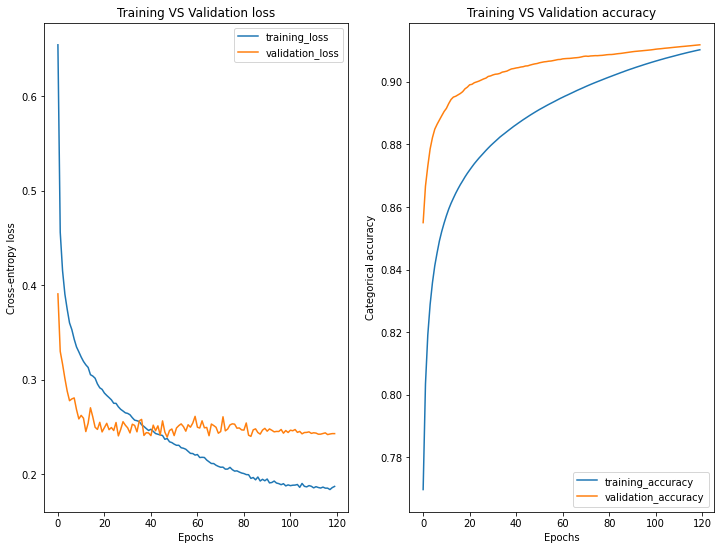

In [ ]:
plot_training_history(EPOCHS_NUM, training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history)

# **Evaluation**

In [ ]:
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
print("Test accuracy of the base model: {}".format(evaluation_loop(improved_model, test_data_pre, test_acc_metric)))

Test accuracy of the base model: 0.9009000062942505
